# 01__preprocess_mpranalyze_quantify

Re-shape counts to be in the input format needed to run MPRAnalyze. [note: negative controls in the quantification model are just random sequences, expected to have no activity].

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import sys

from scipy.stats import spearmanr

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

## functions

In [4]:
def get_barc_id(row):
    str_split = row.tile_id.split(".")
    return str_split[-1]

In [5]:
def dna_status(row, barc_thresh, perc_barc_thresh, ctrl_elems):
    samp_cols = [x for x in row.index if "samp:" in x]
    vals = row[samp_cols]
    if row.element not in ctrl_elems:
        tot_barcs = len(vals)
        n_barcs_above_thresh = len([x for x in vals if x >= barc_thresh])
        perc_barcs_above_thresh = n_barcs_above_thresh / tot_barcs
        if perc_barcs_above_thresh >= perc_barc_thresh:
            return "good"
        else:
            return "bad"
    else:
        return "good"

In [6]:
def get_ctrl_status(row):
    if pd.isnull(row.tile_type):
        return False
    elif row.tile_type == "RANDOM":
        return True
    else:
        return False

## variables

In [7]:
counts_dir = "../../../data/01_counts"

In [8]:
CM_data_f = "%s/CM__all_counts_final.5.txt" % counts_dir

In [9]:
index_f = "../../../data/design/Hypertension__pooled.index.txt"

In [10]:
mital_snps_f = "../../../data/design/name_Mital_SNPS.txt"

## 1. import data

In [10]:
CM_data = pd.read_table(CM_data_f, sep="\t")
CM_data.head()

,barcode,dna_1,rep_1,rep_2,rep_3,rep_4,rep_5
0,TAATTTGCGTG,497,86.0,165.0,96.0,86.0,82.0
1,GGTATGTCGGC,255,47.0,33.0,41.0,21.0,46.0
2,GTCGTCAATAA,245,63.0,38.0,60.0,47.0,57.0
3,ATAACATAGGC,46,19.0,2.0,24.0,17.0,17.0
4,ACATTTCGAGG,753,132.0,137.0,103.0,95.0,65.0


In [11]:
index = pd.read_table(index_f, sep="\t")
index_elem = index[["element", "tile_type"]].drop_duplicates()

In [13]:
## mital snps 
mital_snps = pd.read_table(mital_snps_f, sep="\t")
mital_snps.head()

,name
0,chr1:2985619:2985754__rs886940486__1:2985687:C:T
1,chr1:2985628:2985763__1:2985696:G:C__1:2985696...
2,chr1:115259631:115259766__1:115259699:C:G__1:1...
3,chr1:156084367:156084502__1:156084435:A:G__1:1...
4,chr1:156084826:156084961__1:156084894:G:C__1:1...


## 2. merge data w/ index

In [12]:
CM_data.columns = ["barcode", "dna_1", "CM_rep1", "CM_rep2", "CM_rep3", "CM_rep4","CM_rep5"]

In [13]:
df = CM_data.merge(index[["barcode", "element", "tile_type", "tile_id"]], on="barcode")
df["barc_id"] = df.apply(get_barc_id, axis=1).astype(int)
df.head()

,barcode,dna_1,CM_rep1,CM_rep2,CM_rep3,CM_rep4,CM_rep5,element,tile_type,tile_id,barc_id
0,TAATTTGCGTG,497,86.0,165.0,96.0,86.0,82.0,TGTGGTACTTCCCCCTTAGTTCTCCTGTCTCTCTCCTGCTCCTCCA...,WILDTYPE_BUT_HAS_SNP,1719.1.0.0.0.0.8,8
1,GGTATGTCGGC,255,47.0,33.0,41.0,21.0,46.0,TCGGGAGGCTGATGCAGGAGAATCGCTTGAATCTGGGAGGTGGAGT...,WILDTYPE_BUT_HAS_SNP,1956.1.0.0.0.0.1,1
2,GTCGTCAATAA,245,63.0,38.0,60.0,47.0,57.0,CCCTCAATCCAAGTCAATGGCCTCCTGAGAGCTCCATATGACCAGC...,WILDTYPE_SNP_INDIV,1267.1.0.68.0.0.8,8
3,ATAACATAGGC,46,19.0,2.0,24.0,17.0,17.0,TTTTATGTGAAAATGAAGCTCTATAACAACCAAGTCAGGGGACCTA...,WILDTYPE_BUT_HAS_SNP,2550.1.0.0.0.0.11,11
4,ACATTTCGAGG,753,132.0,137.0,103.0,95.0,65.0,TTGCATTGAGATAATGGTAGATTCACATTCATTTCTAAGAAATAAT...,WILDTYPE_SNP_INDIV,4423.1.0.68.0.0.25,25


## 3. create separate df for dna and rna counts

In [14]:
dna_counts = df[["element", "barcode", "tile_type", "barc_id", "dna_1"]]
rna_counts = df[["element", "barcode", "tile_type", "barc_id", "CM_rep1", "CM_rep2", "CM_rep3", "CM_rep4","CM_rep5"]]
rna_counts.head()

,element,barcode,tile_type,barc_id,CM_rep1,CM_rep2,CM_rep3,CM_rep4,CM_rep5
0,TGTGGTACTTCCCCCTTAGTTCTCCTGTCTCTCTCCTGCTCCTCCA...,TAATTTGCGTG,WILDTYPE_BUT_HAS_SNP,8,86.0,165.0,96.0,86.0,82.0
1,TCGGGAGGCTGATGCAGGAGAATCGCTTGAATCTGGGAGGTGGAGT...,GGTATGTCGGC,WILDTYPE_BUT_HAS_SNP,1,47.0,33.0,41.0,21.0,46.0
2,CCCTCAATCCAAGTCAATGGCCTCCTGAGAGCTCCATATGACCAGC...,GTCGTCAATAA,WILDTYPE_SNP_INDIV,8,63.0,38.0,60.0,47.0,57.0
3,TTTTATGTGAAAATGAAGCTCTATAACAACCAAGTCAGGGGACCTA...,ATAACATAGGC,WILDTYPE_BUT_HAS_SNP,11,19.0,2.0,24.0,17.0,17.0
4,TTGCATTGAGATAATGGTAGATTCACATTCATTTCTAAGAAATAAT...,ACATTTCGAGG,WILDTYPE_SNP_INDIV,25,132.0,137.0,103.0,95.0,65.0


In [15]:
dna_counts = dna_counts.sort_values(by=["element", "barc_id"])
rna_counts = rna_counts.sort_values(by=["element", "barc_id"])

## 4. library depth correction

In [16]:
dna_counts_elem = dna_counts.groupby(["element", "tile_type"])["dna_1"].agg("sum").reset_index()
dna_counts_elem = dna_counts_elem[["element", "dna_1"]]
dna_counts_elem.set_index("element", inplace=True)
dna_counts_elem.head()

,dna_1
element,
AAAAAAAAAAAAAAAAAAAAAAAAAATTAGCCAGACATGTTGGCAGGCATCTGTGGTCCCAGCTGCTAAGGGTACTGAGGTAGAAGGGTGGCTTGAGCCTGGGAGGTCAAGGCTGCAGTCAGCCGTGTTCATACC,6912
AAAAAAAAAAAAAAAAAAAAAAAAAATTAGCCAGACATGTTGGCAGGCATCTGTGGTCCCAGCTGCTTAGGGTACTGAGGTAGAAGGGTGGCTTGAGCCTGGGAGGTCAAGGCTGCAGTCAGCCGTGTTCATACC,8102
AAAAAAAAAAAAAAAAAAAAAAGGCTGGGCGTGGTGGCGGGCGCCTATAATCCCAGCTACAGCCACTAAGGAAGCTGAGGCAGCAGAACCATTTGAACCCAGGAGGCAGAGGTTGCAGGGAGCCAAGATCGCGCC,8667
AAAAAAAAAAAAAAAAAAAAAAGGCTGGGCGTGGTGGCGGGCGCCTATAATCCCAGCTACAGCCACTCAGGAAGCTGAGGCAGCAGAACCATTTGAACCCAGGAGGCAGAGGTTGCAGGGAGCCAAGATCGCGCC,8311
AAAAAAAAAAAAAAAAAAAGATACTTATTTTTGTCCTTTAAACAAGGATAGGTAGGGGGTTCTTGTTATCCAGGAAAGTCTTTTTGTTGCAAATAGCTTTCTGCCTAGATGAAGCTTGACTGTTAGTTATGCCCT,1878


In [17]:
rna_counts_elem = rna_counts.groupby(["element", "tile_type"])["CM_rep1", "CM_rep2", "CM_rep3", "CM_rep4","CM_rep5"].agg("sum").reset_index()
rna_counts_elem = rna_counts_elem[["element", "CM_rep1", "CM_rep2", "CM_rep3", "CM_rep4","CM_rep5"]]
rna_counts_elem.set_index("element", inplace=True)
rna_counts_elem.head()

,CM_rep1,CM_rep2,CM_rep3,CM_rep4,CM_rep5
element,,,,,
AAAAAAAAAAAAAAAAAAAAAAAAAATTAGCCAGACATGTTGGCAGGCATCTGTGGTCCCAGCTGCTAAGGGTACTGAGGTAGAAGGGTGGCTTGAGCCTGGGAGGTCAAGGCTGCAGTCAGCCGTGTTCATACC,1282.0,1202.0,1149.0,996.0,1029.0
AAAAAAAAAAAAAAAAAAAAAAAAAATTAGCCAGACATGTTGGCAGGCATCTGTGGTCCCAGCTGCTTAGGGTACTGAGGTAGAAGGGTGGCTTGAGCCTGGGAGGTCAAGGCTGCAGTCAGCCGTGTTCATACC,1361.0,1217.0,1302.0,1102.0,1182.0
AAAAAAAAAAAAAAAAAAAAAAGGCTGGGCGTGGTGGCGGGCGCCTATAATCCCAGCTACAGCCACTAAGGAAGCTGAGGCAGCAGAACCATTTGAACCCAGGAGGCAGAGGTTGCAGGGAGCCAAGATCGCGCC,2604.0,2520.0,2379.0,2154.0,1974.0
AAAAAAAAAAAAAAAAAAAAAAGGCTGGGCGTGGTGGCGGGCGCCTATAATCCCAGCTACAGCCACTCAGGAAGCTGAGGCAGCAGAACCATTTGAACCCAGGAGGCAGAGGTTGCAGGGAGCCAAGATCGCGCC,2555.0,2349.0,2438.0,2126.0,2132.0
AAAAAAAAAAAAAAAAAAAGATACTTATTTTTGTCCTTTAAACAAGGATAGGTAGGGGGTTCTTGTTATCCAGGAAAGTCTTTTTGTTGCAAATAGCTTTCTGCCTAGATGAAGCTTGACTGTTAGTTATGCCCT,408.0,392.0,376.0,343.0,397.0


## 5. create annotation file for library depth correction

In [18]:
# col annotations for depth estimation
dna_depth_anns = {"dna_1": {"sample": "1", "condition": "dna"}}
rna_depth_anns = {"CM_rep1": {"sample": "1", "condition": "CM"}, 
                  "CM_rep2": {"sample": "2", "condition": "CM"},
                  "CM_rep3": {"sample": "3", "condition": "CM"},
                  "CM_rep4": {"sample": "4", "condition": "CM"},
                  "CM_rep5": {"sample": "5", "condition": "CM"}}

dna_depth_anns = pd.DataFrame.from_dict(dna_depth_anns).T
rna_depth_anns = pd.DataFrame.from_dict(rna_depth_anns).T
rna_depth_anns

,sample,condition
CM_rep1,1,CM
CM_rep2,2,CM
CM_rep3,3,CM
CM_rep4,4,CM
CM_rep5,5,CM


## 6. write library depth correction files

In [19]:
# write depth estimation files
mpranalyze_dir = "%s/mpranalyze_files" % counts_dir

dna_depth_anns.to_csv("%s/dna_col_ann.for_depth_estimation.mpranalyze.CM.5.txt" % mpranalyze_dir, sep="\t")
rna_depth_anns.to_csv("%s/rna_col_ann.for_depth_estimation.mpranalyze.CM.5.txt" % mpranalyze_dir, sep="\t")

dna_counts_elem.to_csv("%s/dna_counts.for_depth_estimation.mpranalyze.CM.5.txt" % mpranalyze_dir, sep="\t", index=True)
rna_counts_elem.to_csv("%s/rna_counts.for_depth_estimation.mpranalyze.CM.5.txt" % mpranalyze_dir, sep="\t", index=True)

## 7. to run MPRAnalyze, get data in pivot format (opposite of tidy format)

In [37]:
# first filter to the TSSs we care about quantifying
test_elems = list(index[index["tile_type"].str.contains("WILDTYPE")]["element"].unique())
ctrl_elems = list(index[index["tile_type"] == "RANDOM"]["element"].unique())
pos_ctrl_elems = list(index[index["tile_type"].str.contains("CONTROL")]["element"].unique())
print(len(test_elems))
print(len(ctrl_elems))
print(len(pos_ctrl_elems))
good_elems = test_elems + ctrl_elems
len(good_elems)

9341
335
42


9676

In [38]:
dna_counts_filt = dna_counts[dna_counts["element"].isin(good_elems)]
rna_counts_filt = rna_counts[rna_counts["element"].isin(good_elems)]
len(rna_counts_filt)

191931

In [39]:
dna_counts_pos_ctrls = dna_counts[dna_counts["element"].isin(pos_ctrl_elems)]
rna_counts_pos_ctrls = rna_counts[rna_counts["element"].isin(pos_ctrl_elems)]
len(rna_counts_pos_ctrls)

3602

In [24]:
rna_counts_heatmap = rna_counts[rna_counts["element"].isin(good_elems)]

Text(0.5, 0.98, 'pearson correlation of replicates\nlog10+1 counts of all barcodes')

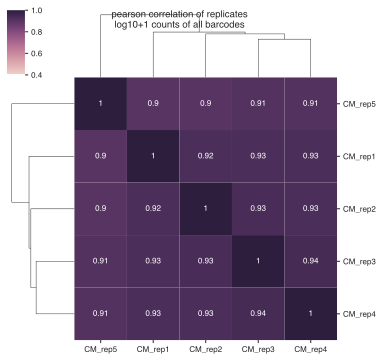

In [25]:
tmp = rna_counts_heatmap
tmp = tmp.set_index("barcode")
tmp.drop(["element","tile_type","barc_id"], axis=1, inplace=True)
tmp_cols = tmp.columns
tmp[tmp_cols] = np.log10(tmp[tmp_cols] + 1)
tmp_corr = tmp.corr(method="pearson")

cmap = sns.cubehelix_palette(as_cmap=True)
cg = sns.clustermap(tmp_corr, figsize=(5, 5), cmap=cmap, annot=True, vmin=0.4)
_ = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.suptitle("pearson correlation of replicates\nlog10+1 counts of all barcodes")

#cg.savefig("rep_and_lib_corr_heatmap_CM.5.Mital.svg", dpi="figure", bbox_inches="tight")

In [40]:
dna_counts_filt = dna_counts_filt.melt(id_vars=["element", "barcode", "tile_type", "barc_id"])
rna_counts_filt = rna_counts_filt.melt(id_vars=["element", "barcode", "tile_type", "barc_id"])
rna_counts_filt.head()

,element,barcode,tile_type,barc_id,variable,value
0,AAAAAAAAAAAAAAAAAAAAAAAAAATTAGCCAGACATGTTGGCAG...,AAACACAGCTA,WILDTYPE_SNP_INDIV,1,CM_rep1,40.0
1,AAAAAAAAAAAAAAAAAAAAAAAAAATTAGCCAGACATGTTGGCAG...,CGACGTGTAAA,WILDTYPE_SNP_INDIV,2,CM_rep1,91.0
2,AAAAAAAAAAAAAAAAAAAAAAAAAATTAGCCAGACATGTTGGCAG...,CTAGTCGGCTA,WILDTYPE_SNP_INDIV,3,CM_rep1,1.0
3,AAAAAAAAAAAAAAAAAAAAAAAAAATTAGCCAGACATGTTGGCAG...,ATGTTCGTATC,WILDTYPE_SNP_INDIV,4,CM_rep1,115.0
4,AAAAAAAAAAAAAAAAAAAAAAAAAATTAGCCAGACATGTTGGCAG...,GCAGCGTGCAA,WILDTYPE_SNP_INDIV,5,CM_rep1,NaN


In [41]:
dna_counts_pos_ctrls = dna_counts_pos_ctrls.melt(id_vars=["element", "barcode", "tile_type", "barc_id"])
rna_counts_pos_ctrls = rna_counts_pos_ctrls.melt(id_vars=["element", "barcode", "tile_type", "barc_id"])
rna_counts_pos_ctrls.head()

,element,barcode,tile_type,barc_id,variable,value
0,AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...,GACCTATACGC,CONTROL_SNP_INDIV,1,CM_rep1,32.0
1,AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...,TTCGGCGTAGA,CONTROL_SNP_INDIV,2,CM_rep1,42.0
2,AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...,AAGATTACGTA,CONTROL_SNP_INDIV,3,CM_rep1,17.0
3,AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...,GTAGAACGATA,CONTROL_SNP_INDIV,4,CM_rep1,97.0
4,AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...,TTTGGAAACCG,CONTROL_SNP_INDIV,5,CM_rep1,63.0


In [42]:
dna_counts_filt["samp_id"] = "samp:" + dna_counts_filt["variable"] + "__barc:" + dna_counts_filt["barc_id"].astype(str)
rna_counts_filt["samp_id"] = "samp:" + rna_counts_filt["variable"] + "__barc:" + rna_counts_filt["barc_id"].astype(str)
rna_counts_filt.sample(5)

,element,barcode,tile_type,barc_id,variable,value,samp_id
103636,GAGATGGCATCATGAGAGTAAATTTAAAAATAAATGCATGTCATGT...,TGCCGGTAGAA,WILDTYPE_BUT_HAS_SNP,11,CM_rep1,17.0,samp:CM_rep1__barc:11
361716,TGGGGCTACAGGCACACACCACCATGCCCAGCTAATTTTTTGCATT...,CGAGAATCGTC,WILDTYPE_SNP_INDIV,24,CM_rep2,222.0,samp:CM_rep2__barc:24
474295,CTGATAAAAGGACTCTACCACCAATAAGCAAATTAAAACATGGTTG...,ACGTCGAAATC,WILDTYPE_SNP_INDIV,14,CM_rep3,12.0,samp:CM_rep3__barc:14
892541,GGGATCCCACCCCAAACCCAGCTGCCTCTGTCCTCTAGGCCTCAGT...,GTGCGGTAAGA,WILDTYPE_BUT_HAS_SNP,18,CM_rep5,41.0,samp:CM_rep5__barc:18
303117,GCAGCTTCTCGGCAAAGTACTCATTCGCGGGCCGGCAGTGCAGCTC...,CAACGATCGTC,WILDTYPE_SNP_INDIV,25,CM_rep2,175.0,samp:CM_rep2__barc:25


In [43]:
dna_counts_pos_ctrls["samp_id"] = "samp:" + dna_counts_pos_ctrls["variable"] + "__barc:" + dna_counts_pos_ctrls["barc_id"].astype(str)
rna_counts_pos_ctrls["samp_id"] = "samp:" + rna_counts_pos_ctrls["variable"] + "__barc:" + rna_counts_pos_ctrls["barc_id"].astype(str)
rna_counts_pos_ctrls.sample(5)

,element,barcode,tile_type,barc_id,variable,value,samp_id
2949,TCCACCCTGGCCTGCTTTAGCTTTCCCCAGACATGGCCAACAAGGG...,ATACGGTAACA,CONTROL_SNP_INDIV,44,CM_rep1,197.0,samp:CM_rep1__barc:44
7623,ACAGACAATAACTCAGTGCCTGGCAAACAGTGAGCACTATGCAAAC...,GCTCACGTCGT,CONTROL_SNP_INDIV,35,CM_rep3,4.0,samp:CM_rep3__barc:35
13003,GAAGCGCTGAGGAGAGAGGGTTGTAGAGAGGGGAAGAATGGGGACG...,CCTCGTGACGA,CONTROL_SNP_INDIV,62,CM_rep4,645.0,samp:CM_rep4__barc:62
9765,GCGAGCCAGTGGGGGAGGCTGACATCACCACGGCGGCAGCCCTTTA...,CTTCAAACAGC,CONTROL_SNP_INDIV,85,CM_rep3,40.0,samp:CM_rep3__barc:85
5740,GAAGCGCTGAGGAGAGAGGGTTGTAGAGAGGGGAAGAATGGGGACG...,GCAACGGTGTC,CONTROL_SNP_INDIV,2,CM_rep2,569.0,samp:CM_rep2__barc:2


In [44]:
dna_counts_piv = dna_counts_filt.pivot_table(index="element", columns="samp_id", values="value").reset_index()
rna_counts_piv = rna_counts_filt.pivot_table(index="element", columns="samp_id", values="value").reset_index()
rna_counts_piv.head()

samp_id,element,samp:CM_rep1__barc:1,samp:CM_rep1__barc:10,samp:CM_rep1__barc:11,samp:CM_rep1__barc:12,samp:CM_rep1__barc:13,samp:CM_rep1__barc:14,samp:CM_rep1__barc:15,samp:CM_rep1__barc:16,samp:CM_rep1__barc:17,...,samp:CM_rep5__barc:23,samp:CM_rep5__barc:24,samp:CM_rep5__barc:25,samp:CM_rep5__barc:3,samp:CM_rep5__barc:4,samp:CM_rep5__barc:5,samp:CM_rep5__barc:6,samp:CM_rep5__barc:7,samp:CM_rep5__barc:8,samp:CM_rep5__barc:9
0,AAAAAAAAAAAAAAAAAAAAAAAAAATTAGCCAGACATGTTGGCAG...,40.0,147.0,33.0,56.0,8.0,43.0,58.0,44.0,29.0,...,71.0,128.0,NaN,24.0,146.0,1.0,46.0,7.0,NaN,46.0
1,AAAAAAAAAAAAAAAAAAAAAAAAAATTAGCCAGACATGTTGGCAG...,55.0,33.0,64.0,47.0,1.0,21.0,34.0,47.0,34.0,...,53.0,157.0,17.0,8.0,17.0,100.0,9.0,7.0,43.0,21.0
2,AAAAAAAAAAAAAAAAAAAAAAGGCTGGGCGTGGTGGCGGGCGCCT...,36.0,28.0,NaN,205.0,47.0,112.0,NaN,100.0,17.0,...,NaN,20.0,152.0,63.0,NaN,185.0,12.0,342.0,32.0,71.0
3,AAAAAAAAAAAAAAAAAAAAAAGGCTGGGCGTGGTGGCGGGCGCCT...,9.0,24.0,17.0,104.0,NaN,104.0,26.0,16.0,38.0,...,42.0,71.0,100.0,149.0,85.0,326.0,60.0,119.0,4.0,130.0
4,AAAAAAAAAAAAAAAAAAAGATACTTATTTTTGTCCTTTAAACAAG...,52.0,NaN,37.0,73.0,NaN,7.0,85.0,NaN,3.0,...,NaN,7.0,8.0,NaN,22.0,50.0,NaN,26.0,1.0,8.0


In [45]:
dna_counts_pos_ctrl_piv = dna_counts_pos_ctrls.pivot(index="element", columns="samp_id", values="value").reset_index()
rna_counts_pos_ctrl_piv = rna_counts_pos_ctrls.pivot(index="element", columns="samp_id", values="value").reset_index()
rna_counts_pos_ctrl_piv.head()

samp_id,element,samp:CM_rep1__barc:1,samp:CM_rep1__barc:10,samp:CM_rep1__barc:100,samp:CM_rep1__barc:11,samp:CM_rep1__barc:12,samp:CM_rep1__barc:13,samp:CM_rep1__barc:14,samp:CM_rep1__barc:15,samp:CM_rep1__barc:16,...,samp:CM_rep5__barc:90,samp:CM_rep5__barc:91,samp:CM_rep5__barc:92,samp:CM_rep5__barc:93,samp:CM_rep5__barc:94,samp:CM_rep5__barc:95,samp:CM_rep5__barc:96,samp:CM_rep5__barc:97,samp:CM_rep5__barc:98,samp:CM_rep5__barc:99
0,AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...,32.0,85.0,87.0,348.0,111.0,164.0,531.0,171.0,111.0,...,39.0,178.0,175.0,5.0,500.0,5.0,178.0,208.0,176.0,621.0
1,AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...,248.0,1140.0,235.0,809.0,142.0,518.0,290.0,86.0,240.0,...,159.0,801.0,289.0,312.0,261.0,367.0,903.0,985.0,699.0,67.0
2,AACAGTGAAAATGATAATTCAAACTAATACTGTTTACAGGGAGTTA...,NaN,60.0,105.0,115.0,7.0,NaN,89.0,8.0,24.0,...,29.0,27.0,11.0,22.0,13.0,NaN,15.0,59.0,43.0,25.0
3,AACAGTGAAAATGATAATTCAAACTAATACTGTTTACAGGGAGTTA...,206.0,40.0,230.0,74.0,24.0,431.0,121.0,75.0,89.0,...,25.0,44.0,6.0,31.0,88.0,5.0,NaN,12.0,17.0,52.0
4,ACAGACAATAACTCAGTGCCTGGCAAACAGTGAGCACTATGCAAAC...,29.0,71.0,9.0,5.0,117.0,73.0,75.0,55.0,57.0,...,74.0,16.0,9.0,102.0,49.0,26.0,39.0,42.0,138.0,73.0


In [46]:
dna_counts_piv.fillna(0, inplace=True)
rna_counts_piv.fillna(0, inplace=True)
rna_counts_piv.head()

samp_id,element,samp:CM_rep1__barc:1,samp:CM_rep1__barc:10,samp:CM_rep1__barc:11,samp:CM_rep1__barc:12,samp:CM_rep1__barc:13,samp:CM_rep1__barc:14,samp:CM_rep1__barc:15,samp:CM_rep1__barc:16,samp:CM_rep1__barc:17,...,samp:CM_rep5__barc:23,samp:CM_rep5__barc:24,samp:CM_rep5__barc:25,samp:CM_rep5__barc:3,samp:CM_rep5__barc:4,samp:CM_rep5__barc:5,samp:CM_rep5__barc:6,samp:CM_rep5__barc:7,samp:CM_rep5__barc:8,samp:CM_rep5__barc:9
0,AAAAAAAAAAAAAAAAAAAAAAAAAATTAGCCAGACATGTTGGCAG...,40.0,147.0,33.0,56.0,8.0,43.0,58.0,44.0,29.0,...,71.0,128.0,0.0,24.0,146.0,1.0,46.0,7.0,0.0,46.0
1,AAAAAAAAAAAAAAAAAAAAAAAAAATTAGCCAGACATGTTGGCAG...,55.0,33.0,64.0,47.0,1.0,21.0,34.0,47.0,34.0,...,53.0,157.0,17.0,8.0,17.0,100.0,9.0,7.0,43.0,21.0
2,AAAAAAAAAAAAAAAAAAAAAAGGCTGGGCGTGGTGGCGGGCGCCT...,36.0,28.0,0.0,205.0,47.0,112.0,0.0,100.0,17.0,...,0.0,20.0,152.0,63.0,0.0,185.0,12.0,342.0,32.0,71.0
3,AAAAAAAAAAAAAAAAAAAAAAGGCTGGGCGTGGTGGCGGGCGCCT...,9.0,24.0,17.0,104.0,0.0,104.0,26.0,16.0,38.0,...,42.0,71.0,100.0,149.0,85.0,326.0,60.0,119.0,4.0,130.0
4,AAAAAAAAAAAAAAAAAAAGATACTTATTTTTGTCCTTTAAACAAG...,52.0,0.0,37.0,73.0,0.0,7.0,85.0,0.0,3.0,...,0.0,7.0,8.0,0.0,22.0,50.0,0.0,26.0,1.0,8.0


In [47]:
dna_counts_pos_ctrl_piv.fillna(0, inplace=True)
rna_counts_pos_ctrl_piv.fillna(0, inplace=True)

## 8. filter: remove any elements that don't have >=50% of barcodes with DNA counts >= 10

In [48]:
dna_counts_piv["dna_status"] = dna_counts_piv.apply(dna_status, barc_thresh=10, perc_barc_thresh=0.5, 
                                                    ctrl_elems=ctrl_elems, axis=1)
dna_counts_pos_ctrl_piv["dna_status"] = dna_counts_pos_ctrl_piv.apply(dna_status, barc_thresh=10, 
                                                                      perc_barc_thresh=0.5, 
                                                                      ctrl_elems=ctrl_elems, axis=1)
dna_counts_piv.dna_status.value_counts()

good    8343
bad     1328
Name: dna_status, dtype: int64

In [31]:
good_dna_elems = list(rna_counts_piv["element"])

In [49]:
good_dna_elems = list(rna_counts_piv["element"])
good_pos_ctrl_dna_elems = list(rna_counts_pos_ctrl_piv["element"])

In [50]:
dna_counts_piv_filt = dna_counts_piv[dna_counts_piv["element"].isin(good_dna_elems)]
dna_counts_piv_filt.drop("dna_status", axis=1, inplace=True)
rna_counts_piv_filt = rna_counts_piv[rna_counts_piv["element"].isin(good_dna_elems)]
print(len(dna_counts_piv_filt))
print(len(rna_counts_piv_filt))

9671
9671


In [51]:
dna_counts_pos_ctrl_piv_filt = dna_counts_pos_ctrl_piv[dna_counts_pos_ctrl_piv["element"].isin(good_pos_ctrl_dna_elems)]
dna_counts_pos_ctrl_piv_filt.drop("dna_status", axis=1, inplace=True)
rna_counts_pos_ctrl_piv_filt = rna_counts_pos_ctrl_piv[rna_counts_pos_ctrl_piv["element"].isin(good_pos_ctrl_dna_elems)]
print(len(dna_counts_pos_ctrl_piv_filt))
print(len(rna_counts_pos_ctrl_piv_filt))

42
42


In [52]:
## merge 
dna_counts_piv_filt = dna_counts_pos_ctrl_piv_filt.append(dna_counts_piv_filt)
dna_counts_piv_filt.shape

(9713, 101)

In [54]:
rna_counts_piv_filt = rna_counts_pos_ctrl_piv_filt.append(rna_counts_piv_filt)
rna_counts_piv_filt.shape

(9713, 501)

## 9. get negative control IDs [negative controls only for quantification]

In [55]:
ctrls = rna_counts_piv_filt[["element"]].merge(index_elem[["element", "tile_type"]], on="element", how="left")
print(len(ctrls))
ctrls.head()

9713


,element,tile_type
0,AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...,CONTROL_SNP_INDIV
1,AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...,CONTROL_BUT_HAS_SNP
2,AACAGTGAAAATGATAATTCAAACTAATACTGTTTACAGGGAGTTA...,CONTROL_SNP_INDIV
3,AACAGTGAAAATGATAATTCAAACTAATACTGTTTACAGGGAGTTA...,CONTROL_BUT_HAS_SNP
4,ACAGACAATAACTCAGTGCCTGGCAAACAGTGAGCACTATGCAAAC...,CONTROL_SNP_INDIV


In [56]:
rna_counts_piv_filt.head()

samp_id,element,samp:CM_rep1__barc:1,samp:CM_rep1__barc:10,samp:CM_rep1__barc:100,samp:CM_rep1__barc:11,samp:CM_rep1__barc:12,samp:CM_rep1__barc:13,samp:CM_rep1__barc:14,samp:CM_rep1__barc:15,samp:CM_rep1__barc:16,...,samp:CM_rep5__barc:90,samp:CM_rep5__barc:91,samp:CM_rep5__barc:92,samp:CM_rep5__barc:93,samp:CM_rep5__barc:94,samp:CM_rep5__barc:95,samp:CM_rep5__barc:96,samp:CM_rep5__barc:97,samp:CM_rep5__barc:98,samp:CM_rep5__barc:99
0,AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...,32.0,85.0,87.0,348.0,111.0,164.0,531.0,171.0,111.0,...,39.0,178.0,175.0,5.0,500.0,5.0,178.0,208.0,176.0,621.0
1,AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...,248.0,1140.0,235.0,809.0,142.0,518.0,290.0,86.0,240.0,...,159.0,801.0,289.0,312.0,261.0,367.0,903.0,985.0,699.0,67.0
2,AACAGTGAAAATGATAATTCAAACTAATACTGTTTACAGGGAGTTA...,0.0,60.0,105.0,115.0,7.0,0.0,89.0,8.0,24.0,...,29.0,27.0,11.0,22.0,13.0,0.0,15.0,59.0,43.0,25.0
3,AACAGTGAAAATGATAATTCAAACTAATACTGTTTACAGGGAGTTA...,206.0,40.0,230.0,74.0,24.0,431.0,121.0,75.0,89.0,...,25.0,44.0,6.0,31.0,88.0,5.0,0.0,12.0,17.0,52.0
4,ACAGACAATAACTCAGTGCCTGGCAAACAGTGAGCACTATGCAAAC...,29.0,71.0,9.0,5.0,117.0,73.0,75.0,55.0,57.0,...,74.0,16.0,9.0,102.0,49.0,26.0,39.0,42.0,138.0,73.0


In [57]:
ctrls["ctrl_status"] = ctrls.apply(get_ctrl_status, axis=1)
ctrls.sample(5)

,element,tile_type,ctrl_status
7703,TCAGGAAGCTATTTAAAAATAACAGATCAAGGCCAGGTGCAGTGGC...,WILDTYPE_SNP_INDIV,False
6814,GTGGGGCTAATTTTGTTAAGCTGATGTCCATCTTTCCTATCTCCAC...,WILDTYPE_SNP_INDIV,False
8006,TCTATGTGCCCATCAGTGAGCTACTCCACTGCCTATTTCTACTTCA...,WILDTYPE_BUT_HAS_SNP,False
2579,ATGCTGTTTTGGAACCAAACAGCAGGCTGCCAACTGAAACAACATA...,WILDTYPE_SNP_INDIV,False
9297,TTGGAACACGATTTGTTATAGGGGACCAATCCTCAAATGAGGAAAC...,WILDTYPE_BUT_HAS_SNP,False


In [58]:
ctrls.ctrl_status.value_counts()

False    9378
True      335
Name: ctrl_status, dtype: int64

## 10.create overall annotation file

In [59]:
dna_cols = [x for x in dna_counts_piv_filt.columns if "samp:" in x]
rna_cols = [x for x in rna_counts_piv_filt.columns if "samp:" in x]

In [60]:
dna_col_ann = {}
rna_col_ann = {}
for cols, ann in zip([dna_cols, rna_cols], [dna_col_ann, rna_col_ann]):
    for col in cols:
        samp = col.split("__")[0].split("_")[-1]
        cond = col.split(":")[1].split("_")[0]
        barc = col.split(":")[-1]
        ann[col] = {"sample": samp, "condition": cond, "barcode": barc}

dna_col_ann = pd.DataFrame.from_dict(dna_col_ann, orient="index")
rna_col_ann = pd.DataFrame.from_dict(rna_col_ann, orient="index")
rna_col_ann.sample(5)

,sample,condition,barcode
samp:CM_rep4__barc:89,rep4,CM,89
samp:CM_rep1__barc:73,rep1,CM,73
samp:CM_rep3__barc:61,rep3,CM,61
samp:CM_rep3__barc:53,rep3,CM,53
samp:CM_rep4__barc:38,rep4,CM,38


## 11. write final files [for quantification analysis]

In [61]:
mpranalyze_dir = "../../../data/01_counts/mpranalyze_files"

In [62]:
#dna_counts_piv_filt.set_index("element", inplace=True)
rna_counts_piv_filt.set_index("element", inplace=True)

In [63]:
# write final files
dna_col_ann.to_csv("%s/dna_col_ann.mpranalyze.for_quantification.CM.5.txt" % mpranalyze_dir, sep="\t")
rna_col_ann.to_csv("%s/rna_col_ann.mpranalyze.for_quantification.CM.5.txt" % mpranalyze_dir, sep="\t")

ctrls = ctrls[["element", "ctrl_status"]]
ctrls.to_csv("%s/ctrl_status.mpranalyze.for_quantification.CM.5.txt" % mpranalyze_dir, sep="\t", index=False)

dna_counts_piv_filt.to_csv("%s/dna_counts.mpranalyze.for_quantification.CM.5.txt" % mpranalyze_dir, sep="\t", index=True)
rna_counts_piv_filt.to_csv("%s/rna_counts.mpranalyze.for_quantification.CM.5.txt" % mpranalyze_dir, sep="\t", index=True)